# Predicting Diabetes Prognosis

## Introduction:

Diabetes is a medical condition where the afflicted body is unable to create enough insulin to efficiently transform glucose into energy for the body's utilization. If left undiagnosed and untreated, diabetes can inflict serious harm to a person's heart and blood vessels, eyes, kidneys, nerves, gastrointestinal tract, and gums and teeth. Given the health risks of untreated diabetes, it is imperative that medical professionals have a method of diagnosing the condition as soon as possible. This lead us to our question: *Is it possible to diagnose diabetes in patients based on their medical factors? If so, what medical factors should we use to create the most accuracte predictive model?* To answer these questions, this project intends to create a k-nn classifier model that can predict whether or not a person is diabetic based on their medical factors. The data set that we will use to create this classifier is the Pima Indians Diabetes Dataset, which we obtained from https://github.com/npradaschnor/Pima-Indians-Diabetes-Dataset/blob/master/diabetes.csv. This dataset contains the health information of 768 women from Phoenix, Arizona. 

The dataset contains 9 columns:
1) Outcome (1 is diabetic, 0 is not diabetic)
2) Number of pregnancies
3) Glucose tolerance (Two hour plasma glucose concentration after 75g anhydrous glucose in mg/dl)
4) Blood pressure (Diastolic BP in mmHg)
5) Skin thickness (Triceps skin fold thickness in mm)
6) Insulin (2 hour serum insulin in mu U/ml)
7) BMI (Body Mass Index)
8) Pedigree diabetes function (A function that extrapolates the likelyhood of the onset of    diabetes based on ancestry)
9) Age (Years)

For our classifier, a diabetes diagnosis ("Outcome") will be the target variable and we will choose the predictor variables using forward selection to ensure that we are using the combination of predictor variables that yields the best prediction accuracy.

## Methods and Results

### Our Process

Below is an overview of our data analysis process (a more detailed explaination will be provided at each step)
1) Read and Wrangle the dataset into a tidy dataset.
2) Split the tidy dataset into a training and testing set. 
3) Use forward selection to find the combination of predictor variables with the highest prediction accuracy. 
4) Perform k-nearest neighbor classification with the best value of k found using cross-validation and predict the test set to get the final model accuracy validation.
5) Describe our results and conclusion.

### Loading Relevant Libraries

In [72]:
#RUN THIS CELL 
library(tidyverse)
library(tidymodels)
library(forcats)
library(RColorBrewer)
library(repr)
library(ggplot2)
library(knitr)
options(repr.matrix.max.rows = 20)

### Read and wrangle the dataset from the web into jupyter as a tidy dataset

* We bring the data set from the web into Jupyter using <code>read_csv()</code>. 
* The Outcome column will be our target variable so we make it into a factor variable using <code>as_factor()</code>.
* The resulting dataset is our wrangled <code>diabetes_data</code> with 768 usable observations.

In [73]:
data <- read_csv("https://raw.githubusercontent.com/npradaschnor/Pima-Indians-Diabetes-Dataset/master/diabetes.csv")

diabetes_data <- data |>
mutate(Outcome = as_factor(Outcome))

diabetes_data
print("Table 1.0")

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0
3,78,50,32,88,31.0,0.248,26,1
10,115,0,0,0,35.3,0.134,29,0
2,197,70,45,543,30.5,0.158,53,1


[1] "Table 1.0"


### Summarizing the Training Data

* As a result of our wrangling data step, we know that our data set contains a total of 768 usuable observations
* We have decided to perform a random split of 0.75 so that 75 percent of the data is used as the training set and the remaining 25 percent is used as the testing set. This ensures that we have sufficient data to train our classifier and then evaluate its prediction accuracy.
* Since <code>initial_split()</code> randomly samples the data set and we want our results to be reproducable, we use <code>set.seed()</code> to assign our result to the seed 1234.

In [74]:
set.seed(1234)
diab_split <- initial_split(diabetes_data, prop = 0.75, strata = Outcome)
diab_train <- training(diab_split)
diab_test <- testing(diab_split)

* Our next step is to summarize our data into different tables for exploratory data analysis.  

In [75]:
n_per_Outcome <- diab_train |>
    group_by(Outcome) |> 
    summarize(n = n())
n_per_Outcome
print("Table 1.1")

Outcome,n
<fct>,<int>
0,375
1,201


[1] "Table 1.1"


* Table 1.1 displays the number of observations in each Outcome (1 or 0 where 1 means diabetic and 0 means not diabetic)
* We were able to find the number of observations in each outcome by grouping the data by outcome using <code>group_by(Outcome)</code> and then counting the number of observations in each outcome using <code>summarize(n = n())</code>.
* Table 1.1 shows that there are more patients without diabetes then with diabetes in our training set.

In [76]:
Avg_Preg_Outcome <- diab_train |>
    group_by(Outcome) |> 
    summarize(Mean_Number_Of_Pregnancies = mean(Pregnancies))


#Calculations for showing statistical difference
Calculation1 =  Avg_Preg_Outcome |> 
    filter(Outcome == 0) |>
    select(Mean_Number_Of_Pregnancies)
Calculation2 = Avg_Preg_Outcome |>
    filter(Outcome == 1) |>
    select(Mean_Number_Of_Pregnancies)
Calc_final = (Calculation1/Calculation2 *100)

  colnames(Calc_final) <- c("Percent_Significance") #|>
Avg_Preg_Outcome = Calc_final |> 
    bind_cols(Avg_Preg_Outcome)


Avg_Preg_Outcome
print("Table 1.2")

Percent_Significance,Outcome,Mean_Number_Of_Pregnancies
<dbl>,<fct>,<dbl>
69.72448,0,3.34400
69.72448,1,4.79602


[1] "Table 1.2"


* Table 1.2 reports the average number of pregnancies for diabetic and not diabetic patients
* We found the average number of prenancies for each outcome by grouping the data set by outcome using <code>group_by(Outcome)</code> and then finding the mean number of pregnancies in each group using <code>summarize(Mean_Number_Of_Pregnancies = mean(Pregnancies))</code>.
* Table 1.2 suggests that, on average, diabetic patients have more pregnancies than not diabetic patients.

In [77]:
avg_pred_vals <- diab_train |>
    select(-Outcome) |>
    map_df(mean, na.rm = TRUE)
avg_pred_vals
print("Table 1.3")



Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.850694,121.1094,68.7934,20.41667,80.99479,31.96667,0.4716719,33.22743


[1] "Table 1.3"


* Table 1.3 give the means of the predictor variables.
* First we select all the predictor variables using <code>select(-Outcome)</code> and then use <code>map_df(mean)</code> to find the mean of each predictor variable. <code>Na.rm = TRUE</code> ensures that any empty cells are ignored.

In [78]:
Avg_Age_Outcome <- diab_train |>
    group_by(Outcome) |> 
    summarize(Mean_Age = mean(Age))


#Calculations for showing statistical difference
Calculation1 =  Avg_Age_Outcome |> 
    filter(Outcome == 0) |>
    select(Mean_Age)
Calculation2 = Avg_Age_Outcome |>
    filter(Outcome == 1) |>
    select(Mean_Age)
Calc_final = (Calculation1/Calculation2 *100)

  colnames(Calc_final) <- c("Percent_Significance")

Avg_Age_Outcome = Calc_final |> 
    bind_cols(Avg_Age_Outcome)


Avg_Age_Outcome
print("Table 1.4")

Percent_Significance,Outcome,Mean_Age
<dbl>,<fct>,<dbl>
84.87873,0,31.28267
84.87873,1,36.85572


[1] "Table 1.4"


* Table 1.4 reports the average age of diabetic and not diabetic patients
* We found the average age for each outcome by grouping the data set by outcome using <code>group_by(Outcome)</code> and then finding the mean age in each group using <code>summarize(Mean_Age = mean(Age))</code>.
* Table 1.4 suggests that, on average, diabetic patients are older than not diabetic patients. However, the difference appears to be relatively small.

In [79]:
Avg_DPF_Outcome <- diab_train |>
    group_by(Outcome) |> 
    summarize(Mean_Diabetes_Pedigree_Function = mean(DiabetesPedigreeFunction))

#Calculations for showing statistical difference
Calculation1 =  Avg_DPF_Outcome |> 
    filter(Outcome == 0) |>
    select(Mean_Diabetes_Pedigree_Function)
Calculation2 = Avg_DPF_Outcome |>
    filter(Outcome == 1) |>
    select(Mean_Diabetes_Pedigree_Function)
Calc_final = (Calculation1/Calculation2 *100)

  colnames(Calc_final) <- c("Percent_Significance")

Avg_DPF_Outcome = Calc_final |> 
    bind_cols(Avg_DPF_Outcome)


Avg_DPF_Outcome
print("Table 1.5")

Percent_Significance,Outcome,Mean_Diabetes_Pedigree_Function
<dbl>,<fct>,<dbl>
75.73609,0,0.4242427
75.73609,1,0.5601592


[1] "Table 1.5"


* Table 1.5 reports the average Diabetes Pedigree Function of diabetic and not diabetic patients
* We found the average Diabetes Pedigree Function for each outcome by grouping the data set by outcome using <code>group_by(Outcome)</code> and then finding the mean Diabetes Pedigree Function in each group using <code>summarize(Mean_Diabetes_Pedigree_Function = mean(DiabetesPedigreeFunction))</code>.
* Table 1.5 suggests that, on average, diabetic patients have a higher Diabetes Pedigree Function than not diabetic patients.

In [80]:
Avg_BP_Outcome <- diab_train |>
    group_by(Outcome) |> 
    summarize(Mean_Blood_Pressure = mean(BloodPressure))


#Calculations for showing statistical difference
Calculation1 =  Avg_BP_Outcome |> 
    filter(Outcome == 0) |>
    select(Mean_Blood_Pressure)
Calculation2 = Avg_BP_Outcome |>
    filter(Outcome == 1) |>
    select(Mean_Blood_Pressure)
Calc_final = (Calculation1/Calculation2 *100)

  colnames(Calc_final) <- c("Percent_Significance")

Avg_BP_Outcome = Calc_final |> 
    bind_cols(Avg_BP_Outcome)

Avg_BP_Outcome
print("Table 1.6")

Percent_Significance,Outcome,Mean_Blood_Pressure
<dbl>,<fct>,<dbl>
95.78107,0,67.75200
95.78107,1,70.73632


[1] "Table 1.6"


* Table 1.6 reports the average Blood Pressure of diabetic and not diabetic patients
* We found the average Blood Pressure for each outcome by grouping the data set by outcome using <code>group_by(Outcome)</code> and then finding the mean Blood Pressure in each group using <code>summarize(Mean_Blood_Pressure = mean(BloodPressure))</code>.
* Table 1.6 suggests that, on average, diabetic patients have a higher Blood Pressure than not diabetic patients. However, the difference appears to be relatively small.

While there are differences in predictor variable statistics between diabetic and not diabetic pateints, to ensure that we produce the most accurate classifier we will conduct further analysis to determine the most significant predictors.  

### Determining our Predictors

* We begin our further data analysis by using forward selection to determine which variables from the training set will be used as predictor variables.
* We do this to determine if there are any irrelevant variables in our data set that will negatively impact the classifier's accuracy.
* Sincing determining our predictors is part of tuning our classifier we make sure to use our training set during forward selection.
* The steps of forward selection are as follows:
<ol>
<li>Start with a model having no predictors. </li>
<li>Run the following 3 steps until you run out of predictors: </li>
<ol>
    <li>For each unused predictor, add it to the model to form a candidate model.</li>
    <li>Tune all of the candidate models.</li>
    <li>Update the model to be the candidate model with the highest cross-validation accuracy.</li>
    </ol>
<li>Select the model that provides the best trade-off between accuracy and simplicity. </li>
</ol>

In [ ]:
# we use set.seed(1234) to ensure that the random results that follow are reproducible
set.seed(1234)

diabetes_set <- diab_train

names <- colnames(diabetes_set |>
                   select(-Outcome))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
diabetes_vfold <- vfold_cv(diabetes_set, v = 5, strata = Outcome)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Outcome", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        diabetes_recipe <- recipe(as.formula(model_string), 
                                data = diabetes_set) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(diabetes_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = diabetes_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies
print("Table 1.7")

* Table 1.7 represents the accuracies of all the predictor variable models.
* The accuracy of the model increases as meaningful predictors are added because the model is able to make better predictions. On the other hand, when irrelevant predictors are added the accuracy of the model decreases because the model is taking into account varibles that dont help with predictions.
* Our goal when choosing the number of predictors is to find the middle ground between high accuracy and least number of predictor variables. We find this middle ground by looking for where the accuracy stops significantly increasing with each additional predictor. Thus we chose to use the predictor variables Glucose, Age, BMI, and Diabetes Pedigree Function for our model because the accuracy started to decrease as more predictors were added.

In [ ]:
accuracy_plot <- ggplot(accuracies, aes(x = size, y = accuracy)) + 
geom_line() + 
theme(text = element_text(size = 20)) +
labs(x = "number of predictors", y = "model accuracy")
accuracy_plot
print("Figure 1.0")

* Figure 1.0 displays how the model accuracy reaches its maximum at 4 predictors.

## Distributions of best predictors

[1] "(Figure 1.1)"


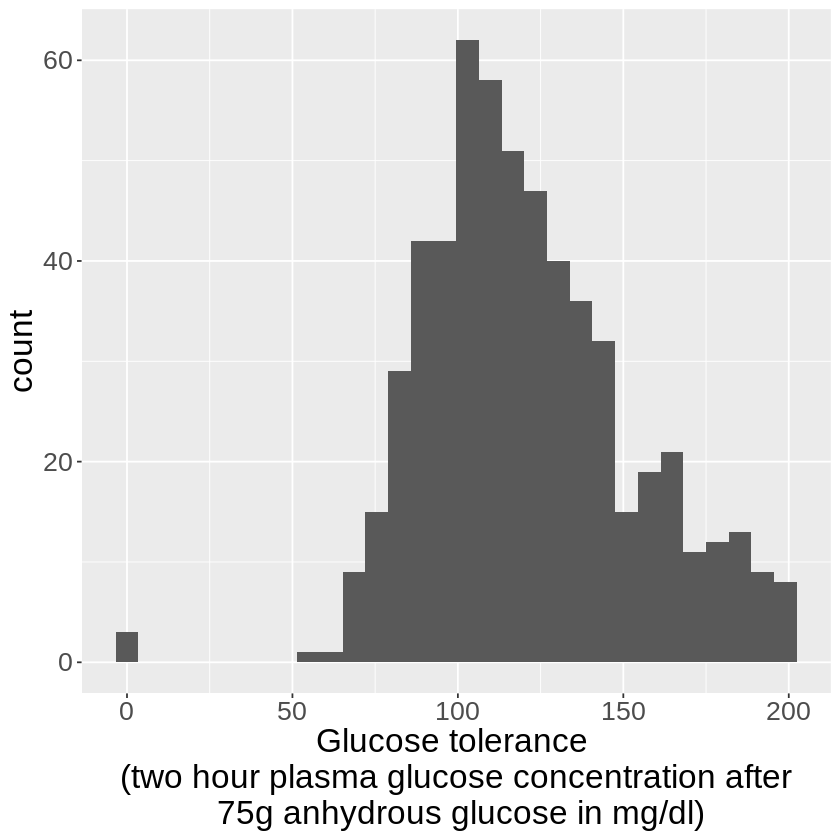

[1] "(Figure 1.2)"


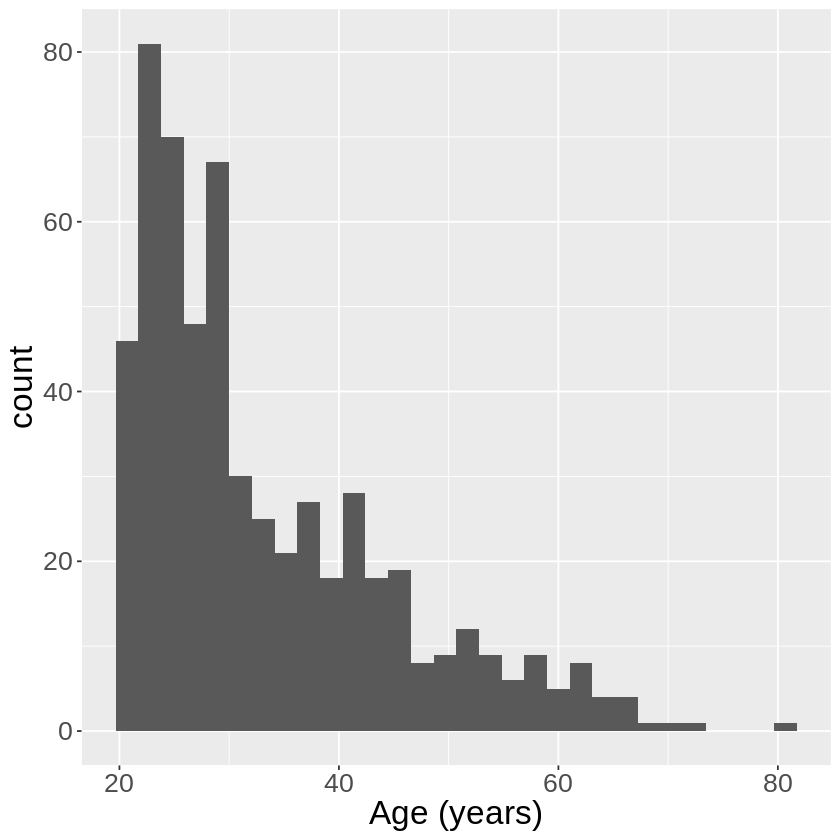

[1] "(Figure 1.3)"


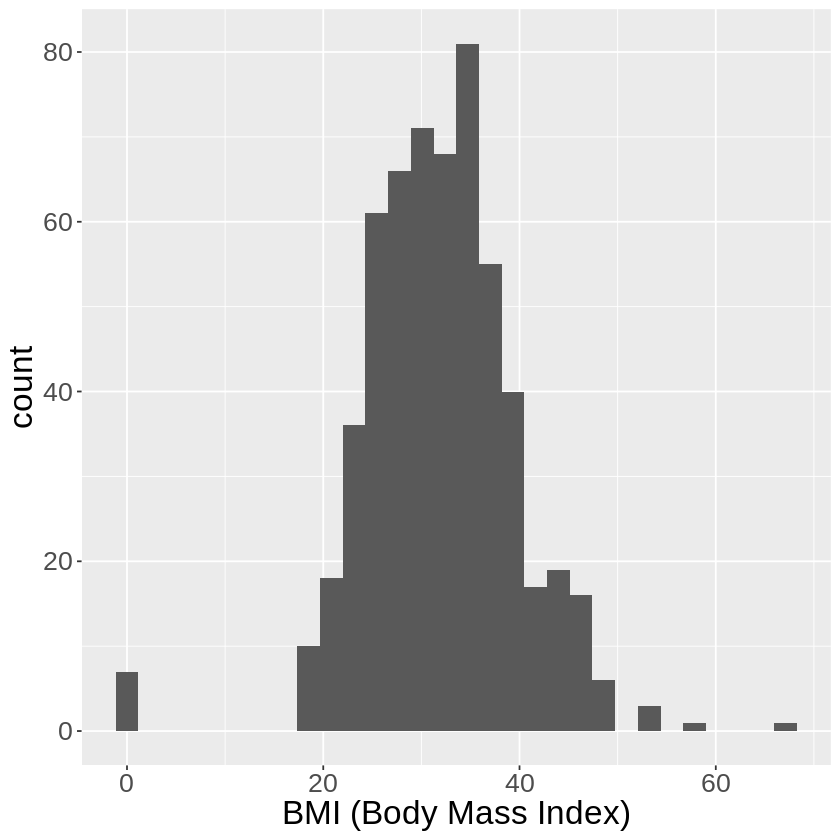

[1] "(Figure 1.4)"


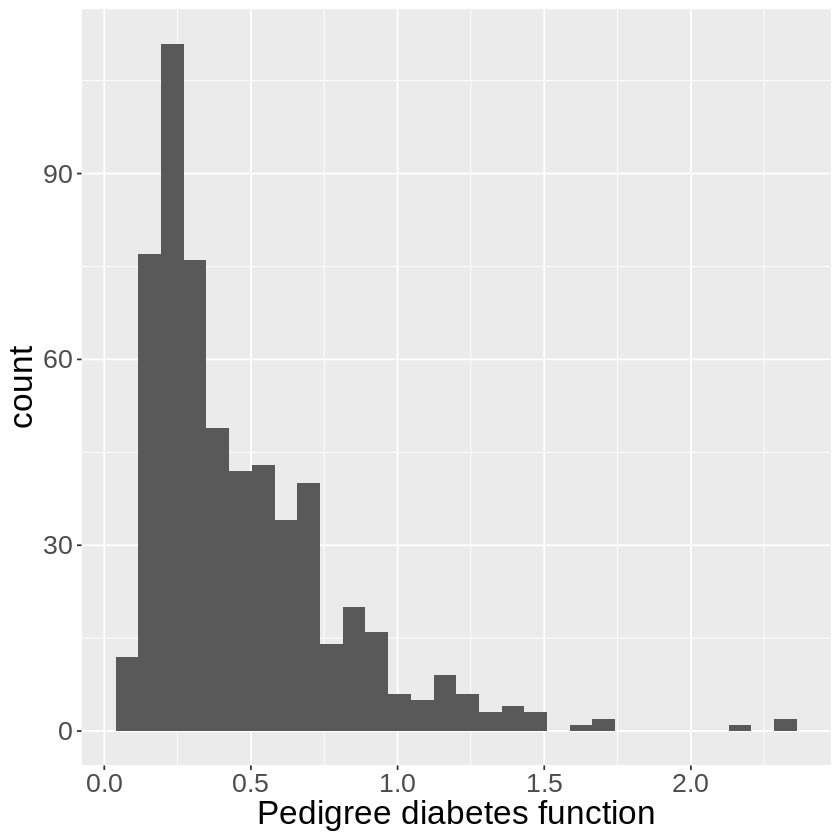

In [81]:
plot_data <- diab_train |>
select(Outcome, Glucose, Age, BMI, DiabetesPedigreeFunction)

Glucose_plot <- plot_data |>
ggplot(aes(x = Glucose)) + 
geom_histogram(bins = 30) +
labs(x = "Glucose tolerance \n (two hour plasma glucose concentration after \n 75g anhydrous glucose in mg/dl)") +
theme(text = element_text(size = 20))

Age_plot <- plot_data |>
ggplot(aes(x = Age)) + 
geom_histogram(bins = 30) +
labs(x = "Age (years)") +
theme(text = element_text(size = 20))

BMI_plot <- plot_data |>
ggplot(aes(x = BMI)) + 
geom_histogram(bins = 30) +
labs(x = "BMI (Body Mass Index)") +
theme(text = element_text(size = 20))

DiabetesPedigreeFunction_plot <- plot_data |>
ggplot(aes(x = DiabetesPedigreeFunction)) + 
geom_histogram(bins = 30) +
labs(x = "Pedigree diabetes function") +
theme(text = element_text(size = 20))

Glucose_plot
print("(Figure 1.1)")
Age_plot
print("(Figure 1.2)")
BMI_plot
print("(Figure 1.3)")
DiabetesPedigreeFunction_plot
print("(Figure 1.4)")

Distribution analysis of Figures 1.1 to 1.4
* Glucose tolerance: slightly skewed right and unimodal.
* Age: skewed right and unimodal.
* BMI: bell-shaped, roughly symmetric, and unimodal.
* Pedigree diabetes function: skewed right and unimodal.

## Tunning the KNN classifier using cross-validation

In [ ]:
# we use set.seed(1234) to ensure that the random results that follow are reproducible
set.seed(1234)

# First we create the standardization recipe using the training data and the predictors Glucose, Age, BMI, Diabetes Pedigree Function.
diabetes_recipe <- recipe(Outcome ~ Glucose + Age + BMI + DiabetesPedigreeFunction, data = diab_train) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

# Next we define the specification for our k-nn model using tune() as the neighbors argument because we are choosing the best k-value for our model.
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

# Next we fit the knn model.
knn_fit <- workflow() |>
add_recipe(diabetes_recipe) |>
add_model(knn_spec) |>
fit(data = diab_train)

# Next we perform cross-validation with 10 folds.
diabetes_vfold <- vfold_cv(diab_train, v = 10, strata = Outcome)

# Next we create a tibble hold k-value 1 to 30.
k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

# Next we use the k_vals tibble to test the accuracy of the model with 1 to 30 neighbors.
knn_results <- workflow() |>
add_recipe(diabetes_recipe) |>
add_model(knn_spec) |>
tune_grid(resamples = diabetes_vfold, grid = k_vals) |>
collect_metrics() 

# Next we use filter() to only select the accuracy values for each k-value in knn_results
accuracies <- knn_results |>
filter(.metric == "accuracy")

# Finally we create a graph of the accuracies plotted against the neighbors to determine the most accurate value of k. 
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
geom_point() +
geom_line() +
labs(x = "Neighbors", y = "Accuracy Estimate") + 
geom_vline(xintercept = 25, colour = "red") +
theme(text = element_text(size = 20))

accuracy_vs_k
print("(Figure 1.5)")
# This visualization suggests that K=25 provides the highest and the most omptimal accuracy.

* Figure 1.5 demonstrates that k = 25 is the best number of neighbors because its accuracy is greater than the others and the accuracy does not fall when we increase the neighbors by 1 and only slightly decreases when we decrease the neighbors by 1. 

## KNN Classification with optimal K

* Now we conduct KNN classification on the test set using our trained model

In [ ]:
# we use set.seed(1234) to ensure that the random results that follow are reproducible
set.seed(1234)

# First we define a new specification for our k-nn model using k = 25 as the neighbors argument  
knn_spec_k25 <- nearest_neighbor(weight_func = "rectangular", neighbors = 25) |> 
    set_engine("kknn") |> 
    set_mode("classification")

# Next we fit the knn model.
diab_fit <- workflow() |>
  add_recipe(diabetes_recipe) |>
  add_model(knn_spec_k25) |>
  fit(data = diab_train)

# Next we use the knn model to make predictions for our test set and bind them to the test set.
diab_predictions <- predict(diab_fit, diab_test) |> 
    bind_cols(diab_test)

# Finally we compare the predictions to the actual outcomes to determine what percent the classifier predicted correctly.
diab_acc <- diab_predictions |> 
    metrics(truth = Outcome, estimate = .pred_class) |> 
    select(.metric, .estimate) |>
    head(1)

diab_acc
print("(Table 1.8)")

* According to table 1.8, our classifier correctly predicted if a patient was diabetic or not for 79.17 percent of the cases in the test set.

## Discussion

As our analysis above has shown, the best predictor variables for our model are glucose tolerance (two hour plasma glucose concentration after 75g anhydrous glucose in mg/dl), age (years), BMI (Body Mass Index), and pedigree diabetes function. As shown in Table 1.8, our classifier created using these variables has a 79.17 percent accuracy level, which is the highest among other predictors. Our team did not expect to these results as we were under the impression that the best preditcor variables were insulin (2 hour serum insulin in mu U/ml), age (years), and BMI (Body Mass Index), which is stated in our group proposal. However, after looking into the pedigree diabetes function further we found that it's a function that estimates the likelihood of diabetes based on family history, which is very relevant since the risk of diabetes increases by 30 percent if one parent was diabetic and by 70% if both parents were diabetic. This makes the pedigree diabtes function a very prominent variable when predicting if a patient is diabetic or not. Additionally, since diabetes in a condition that affects the body's ability to absorb glucose, it makes sense that glucose tolerance is a prominent variable. 

By wrangling and analyzing all the given variables in the dataset, our team was able to see the correlation between variables. The goal of our work is to provide medical professionals with an automated and accurate method of determining if a patient is diabetic. We hope that this will help relieve some of the pressure on the medical industry so that medical professionals have one less task to spend time on and will be able to spend that saved time assisting others. 

Potential future questions and researches that could result from our analysis are as follows:
1. Would our model work if presented with an observation from a male patient? How would we adjust our data accordingly if not?
2. Are there other more relevant predictor variables that weren't included in our data set?
3. Could our model be used to diagnose other medical conditions such as Mastopathy?

## References

* <i>Applications of machine learning in cancer prediction and Prognosis.<i> (n.d.). Retrieved December 3, 2022, from https://journals.sagepub.com/doi/10.1177/117693510600200030 

* <i>Insulin resistance: What it is, causes, symptoms and treatment<i>. Cleveland Clinic. (n.d.). Retrieved December 2, 2022, from https://my.clevelandclinic.org/health/diseases/22206-insulin-resistance#:~:text=As%20long%20as%20your%20pancreas,prediabetes%20and%20Type%202%20diabetes. 

* Møller, N., Gormsen, L., Fuglsang, J., &amp; Gjedsted, J. (2004, November 17). <i>Effects of ageing on insulin secretion and action<i>. Hormone Research in Paediatrics. Retrieved December 2, 2022, from https://www.karger.com/Article/Fulltext/71233 

* Sarahbarb. (n.d.). <i>Prediabetes<i>. Diabetes UK. Retrieved December 2, 2022, from https://www.diabetes.org.uk/preventing-type-2-diabetes/prediabetes 

* <i>Statistics about diabetes<i>. Statistics About Diabetes | ADA. (n.d.). Retrieved December 2, 2022, from https://diabetes.org/about-us/statistics/about-diabetes 

* U.S. Department of Health and Human Services. (n.d.). <i>Prescription medications to treat overweight &amp; obesity<i>. National Institute of Diabetes and Digestive and Kidney Diseases. Retrieved December 2, 2022, from https://www.niddk.nih.gov/health-information/weight-management/prescription-medications-treat-overweight-obesity#:~:text=The%20FDA%20has%20approved%20five,%E2%80%94for%20long%2Dterm%20use. 

* WebMD. (n.d.). <i>What diabetes drugs improve insulin sensitivity?<i> WebMD. Retrieved December 2, 2022, from https://www.webmd.com/diabetes/diabetes-drugs-insulin-sensitivity#:~:text=care%20right%20away.-,Thiazolidinediones%20(TZDs),of%20glucose%20your%20liver%20makes. 